### What we are going to cover

- Using TensorFlow Datasets to download and explore data
- Creating preprocessing function for our data
- Batching & preparing datasets for modeling **(making our datasets run fast)**
- Creating modeling callbacks
- Setting up **mixed precision training**
- Building a feature extraction model 
- Fine-tuning the feature extraction model
- Viewing training results on TensorBoard

## Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in [TensorFlow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html) (a very new feature at the time of writing).

What does **mixed precision training** do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible. 

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+. 

Google Colab offers P100, K80 and T4 GPUs, however, **the P100 and K80 aren't compatible with mixed precision training**.

Therefore before we proceed we need to make sure we have **access to a Tesla T4 GPU in our Google Colab instance**.

If you're not using Google Colab, you can find a list of various [Nvidia GPU compute capabilities on Nvidia's developer website](https://developer.nvidia.com/cuda-gpus#compute).

> 🔑 **Note:** If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.
>
> **You can still run the code *without* a GPU capable of mixed precision** (it'll just be a little slower). 

In [ ]:
# If using Google Colab, this should output "Tesla T4" otherwise
# you won't be able to use mixed precision training
! nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-3df09042-2fc4-0481-0030-7b54c32642ef)


In [ ]:
! nvidia-smi

Wed Mar 30 08:51:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf 
import helper_functions as helper
import os
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dir(helper)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'accuracy_score',
 'calculate_results',
 'compare_histories',
 'confusion_matrix',
 'create_tensorboard_callback',
 'datetime',
 'itertools',
 'load_and_prep_image',
 'make_confusion_matrix',
 'make_f1_scores',
 'np',
 'os',
 'plot_loss_curves',
 'plt',
 'precision_recall_fscore_support',
 'pred_and_plot',
 'predict_image',
 'random',
 'random_predict_16',
 'tf',
 'unzip_data',
 'walk_through_dir',
 'zipfile']

In [ ]:
# Hide waring logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check the tensorflow version
print(tf.__version__)

2.8.0


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
dir(tfds)

['GenerateMode',
 'ImageFolder',
 'ReadConfig',
 'Split',
 'TranslateFolder',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__init__py3',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'api',
 'as_dataframe',
 'as_numpy',
 'audio',
 'builder',
 'builder_cls',
 'core',
 'decode',
 'deprecated',
 'disable_progress_bar',
 'download',
 'even_splits',
 'features',
 'folder_dataset',
 'image',
 'image_classification',
 'is_dataset_on_gcs',
 'list_builders',
 'load',
 'object_detection',
 'proto',
 'public_api',
 'question_answering',
 'show_examples',
 'show_statistics',
 'structured',
 'summarization',
 'sys',
 'testing',
 'text',
 'translate',
 'units',
 'version',
 'video',
 'visualization']

In [ ]:
# to find all of the available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
for i,ds in enumerate(datasets_list):
  print(f"{i} : {ds}")
print(f"food101 in tensorflow_datasets is {'food101' in datasets_list}") # is the dataset we are after available

0 : abstract_reasoning
1 : accentdb
2 : aeslc
3 : aflw2k3d
4 : ag_news_subset
5 : ai2_arc
6 : ai2_arc_with_ir
7 : amazon_us_reviews
8 : anli
9 : arc
10 : bair_robot_pushing_small
11 : bccd
12 : beans
13 : big_patent
14 : bigearthnet
15 : billsum
16 : binarized_mnist
17 : binary_alpha_digits
18 : blimp
19 : bool_q
20 : c4
21 : caltech101
22 : caltech_birds2010
23 : caltech_birds2011
24 : cars196
25 : cassava
26 : cats_vs_dogs
27 : celeb_a
28 : celeb_a_hq
29 : cfq
30 : chexpert
31 : cifar10
32 : cifar100
33 : cifar10_1
34 : cifar10_corrupted
35 : citrus_leaves
36 : cityscapes
37 : civil_comments
38 : clevr
39 : clic
40 : clinc_oos
41 : cmaterdb
42 : cnn_dailymail
43 : coco
44 : coco_captions
45 : coil100
46 : colorectal_histology
47 : colorectal_histology_large
48 : common_voice
49 : coqa
50 : cos_e
51 : cosmos_qa
52 : covid19sum
53 : crema_d
54 : curated_breast_imaging_ddsm
55 : cycle_gan
56 : deep_weeds
57 : definite_pronoun_resolution
58 : dementiabank
59 : diabetic_retinopathy_detect

Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [ ]:
# Load in the data (take 5-6 minutes in Google Colab)
(train_data,test_data),df_info = tfds.load(name = "food101", # target dataset to get from TFDS
                                           split = ["train","validation"], # what splits of data should we get? note: not all datasets have train,valid,test
                                           shuffle_files = True, # shuffle files on download?
                                           as_supervised = True, # download data in tuple format (sample,label) e.g (image,label)
                                           with_info = True # include dataset metadata? if so, tfds.load() return tuple (data,ds_info)
                                           )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMO89R4/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMO89R4/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [ ]:
# features of Food101 TFDS
df_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# get class names
class_names = df_info.features['label'].names
print(f"There are {len(class_names)} labels")
print(class_names[:10])

There are 101 labels
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize". 

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it. 

In [ ]:
# Take one sample off training data
train_one_sample  = train_data.take(1)
# What does one samples of our training data look like
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the image_tensor and label.

In [ ]:
# because we set shuffle_files = True, parameter in our tfds.load() method above, running the cell above
# few times will get a different result each time
# Checking these you might notice some of the images have different shape, for example (512,512,3) or(512,342,3)(height,width,color_channels)
# Let's see what one of the image tensors from TFDS Food101 dataset look like
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class_name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class_name (str form): cheesecake
  


In [ ]:
# Let see what does an image tensor look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
# What are the min and max values
print(f"min value: {tf.reduce_min(image)}")
print(f"max value: {tf.reduce_max(image)}")

min value: 0
max value: 255


Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

(-0.5, 511.5, 511.5, -0.5)

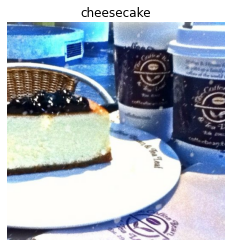

In [ ]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False)

Delicious!

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.preprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model. 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [ ]:
def preprocess_img(image,label,img_shape = 224):
  '''
  Convert image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape,img_shape,color_channel]
  Arguments:
    image --- image from tensorflow dataset
    label --- label of the image (str form)
    img_shape --- size of the image (int form)
  Return:
    preprocessed image,label
  '''
  image = tf.image.resize(image,[img_shape,img_shape])
  #image = image/255. We don't have to normalize
  return tf.cast(image,dtype = tf.float32),label

In [ ]:
# preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing: \n {image[:2]}...,\n Shape: {image.shape}, \n Datatype {image.dtype} \n")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}...,\n Shape: {preprocessed_img.shape}, \n Datatype {preprocessed_img.dtype} \n")

Image before preprocessing: 
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...,
 Shape: (512, 512, 3), 
 Datatype <dtype: 'uint8'> 

Image after preprocessing: 
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
 Shape: (224, 224, 3), 
 Datatype <dtype: 'float32'> 



(-0.5, 223.5, 223.5, -0.5)

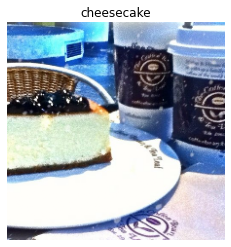

In [ ]:
# Plot preprocessed image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory) 

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying, 

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*

`map -> shuffle -> batch -> prefech -> PrefecthDataset`

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# Map preprocessing function to test data
test_data = test_data.map(preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [ ]:
# Create tensorboard callback (already have 'create_tensorboard_callback()' from a previous notebook)
# Create ModelCheckpoint callback to save model's propress
checkpoint_path  ="./model_checkpoint/cp.ckpt" # Saving weights requires , ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only = True, # only save the best weights
                                                      save_weights_only = True, # only save model weights (not whole model)
                                                      verbose = 1 # don't print out whether or not model is beging saved
                                                      )

## Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

> 📖 **Resource:** If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources). 

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision 
mixed_precision.set_global_policy(policy = 'mixed_float16') # set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [ ]:
mixed_precision.global_policy() # should output 'mixed_float16'

<Policy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

In [ ]:
# Download base model and freeze underlying layers
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable =False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Create functional model
inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer",dtype =tf.float16)
x = base_model(inputs,training = False) # set base_model to inference model only
x = tf.keras.layers.GlobalAveragePooling2D(name = 'pooling_layer')(x) 
x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class
# Seperate acitivation of output layer so we can output float32 activations
outputs = tf.keras.layers.Activation('softmax',dtype = tf.float32,name = 'softmax_float32')(x)
model = tf.keras.Model(inputs,outputs)
# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
# Summary model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [ ]:
# Check the dtype_policy attributes layers in our model
for layer in model.layers:  
  print(f"name: {layer.name} trainable: {layer.trainable} dtype: {layer.dtype} dtype_policy {layer.dtype_policy}") # Check the dtype policy of layers

name: input_layer trainable: True dtype: float16 dtype_policy <Policy "float16">
name: efficientnetb0 trainable: False dtype: float32 dtype_policy <Policy "mixed_float16">
name: pooling_layer trainable: True dtype: float32 dtype_policy <Policy "mixed_float16">
name: dense trainable: True dtype: float32 dtype_policy <Policy "mixed_float16">
name: softmax_float32 trainable: True dtype: float32 dtype_policy <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [ ]:
# Check the layers in the base model and see what dtype policy they are using
for layer in model.layers[1].layers[:20]: # only check the first 20 layer to save ouput space
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs = 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks = [helper.create_tensorboard_callback("training_logs","efficientb0_101_classes_all_data_feature_extract"),
                                                                  model_checkpoint
                                                                  ]
                                                      )

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_feature_extract/20220330-094806
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8227 - accuracy: 0.5575
Epoch 1: val_accuracy improved from -inf to 0.67611, saving model to ./model_checkpoint/cp.ckpt
2368/2368 [==============================] - 228s 89ms/step - loss: 1.8227 - accuracy: 0.5575 - val_loss: 1.2236 - val_accuracy: 0.6761
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2928 - accuracy: 0.6676
Epoch 2: val_accuracy improved from 0.67611 to 0.69783, saving model to ./model_checkpoint/cp.ckpt
2368/2368 [==============================] - 185s 77ms/step - loss: 1.2928 - accuracy: 0.6676 - val_loss: 1.1278 - val_accuracy: 0.6978
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1428 - accuracy: 0.7033
Epoch 3: val_accuracy improved from 0.69783 to 0.70260, saving model to ./model_checkpoint/cp.ckpt
2368/2368 [====================

In [ ]:
# Evaluate model
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 56s 71ms/step - loss: 1.0927 - accuracy: 0.7050


[1.0927225351333618, 0.7050297260284424]

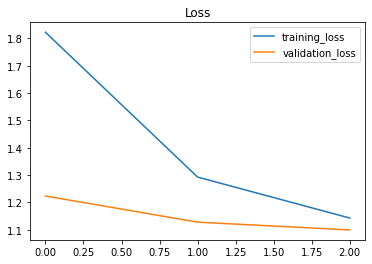

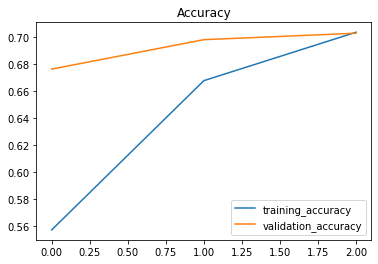

In [ ]:
helper.plot_loss_curves(history_101_food_classes_feature_extract)

And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
cloned_model = tf.keras.models.clone_model(model) # with reset weights
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
!ls model_checkpoint/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
checkpoint_path

'./model_checkpoint/cp.ckpt'

In [ ]:
# Load checkpointed weights into cloned model
cloned_model.load_weights(checkpoint_path)

Each time you make a change to your model (including loading weights), you have to recompile.

In [ ]:
# Evaluate cloned model again
cloned_model.compile(loss = 'sparse_categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
# Evaluate cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 76s 92ms/step - loss: 1.7226 - accuracy: 0.5476


In [ ]:
# Evalutate cloned model with loaded weghts (should be same score as trained model)
np.isclose(results_feature_extract_model,results_cloned_model_with_loaded_weights).all()

False

Cloning the model preserves `dtype_policy`'s of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning with the cloned model, we could and it would still use the mixed precision dtype policy.

In [ ]:
# Check the layers in the base model and see what dtype policy they are using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

## Save the whole model to file

We can also save the whole model using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

> 🔑 **Note:** Saving to Google Drive requires mounting Google Drive (go to Files -> Mount Drive).

In [ ]:
model.save("/content/model_feature_extraction")

INFO:tensorflow:Assets written to: /content/model_feature_extraction/assets


INFO:tensorflow:Assets written to: /content/model_feature_extraction/assets


And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved model
loaded_saved_model = tf.keras.models.load_model('/content/model_feature_extraction')

Loading a `SavedModel` also retains all of the underlying layers `dtype_policy` (we want them to be `"mixed_float16"`).

In [ ]:
# Check the layers in the base model and see what dtype policy they are using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 61s 74ms/step - loss: 1.0927 - accuracy: 0.7050


[1.0927218198776245, 0.7050297260284424]

In [ ]:
np.isclose(results_loaded_saved_model,results_feature_extract_model).all()

True

In [ ]:
! zip -r model_feature_extraction.zip /content/model_feature_extraction

  adding: content/model_feature_extraction/ (stored 0%)
  adding: content/model_feature_extraction/variables/ (stored 0%)
  adding: content/model_feature_extraction/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_feature_extraction/variables/variables.index (deflated 73%)
  adding: content/model_feature_extraction/saved_model.pb (deflated 91%)
  adding: content/model_feature_extraction/assets/ (stored 0%)
  adding: content/model_feature_extraction/keras_metadata.pb (deflated 96%)


And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
# Download the saved model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-03-30 10:59:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  41.2MB/s    in 0.4s    

2022-03-30 10:59:24 (41.2 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Storage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip /content/07_efficientnetb0_feature_extract_model_mixed_precision.zip

Archive:  /content/07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: 07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: 07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: 07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: 07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: 07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: 07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# load and evaluate downloaded GS model
tf.get_logger().setLevel('INFO') # hide warning logs
loaded_gs_model = tf.keras.models.load_model("/content/model_feature_extraction")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Let make sure our model perform well
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 57s 68ms/step - loss: 1.0927 - accuracy: 0.7050


## Load model and fine tuning

In [1]:
# check gpu again, must be T4
! nvidia-smi

Thu Mar 31 07:17:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# import packages
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import random
import tensorflow_datasets as tfds
import helper_functions as helper

In [4]:
!unzip /content/model_feature_extraction.zip -d model_feature_extraction

Archive:  /content/model_feature_extraction.zip
   creating: model_feature_extraction/content/model_feature_extraction/
   creating: model_feature_extraction/content/model_feature_extraction/variables/
  inflating: model_feature_extraction/content/model_feature_extraction/variables/variables.data-00000-of-00001  
  inflating: model_feature_extraction/content/model_feature_extraction/variables/variables.index  
  inflating: model_feature_extraction/content/model_feature_extraction/saved_model.pb  
   creating: model_feature_extraction/content/model_feature_extraction/assets/
  inflating: model_feature_extraction/content/model_feature_extraction/keras_metadata.pb  


In [13]:
# Download dataset food101
(train_data,test_data),ds_info = tfds.load(name = 'food101',
                                           split = ['train','validation'],
                                           shuffle_files = True,
                                           as_supervised = True,
                                           with_info = True
                                           )

In [14]:
# Get class names
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [15]:
# Make a function for preprocessing images, map this function 
def preprocess_img(image,label,image_shape = 224):
  image = tf.image.resize(image,[image_shape,image_shape]) # reshape to im
  return tf.cast(image,tf.float32),label

In [16]:
# Preprocess dataset map -> shuffle -> batch -> refetch 
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.map(map_func = preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size = 1000).batch(batch_size =32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
loaded_model = tf.keras.models.load_model("/content/model_feature_extraction/content/model_feature_extraction")

In [21]:
# Summary model
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [22]:
# Check layer 
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [23]:
# compile the model before evaluate
loaded_model.compile(loss = 'sparse_categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [24]:
# Evaluate your model
result_evaluated_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 66s 65ms/step - loss: 1.0927 - accuracy: 0.7050


## A couple more callbacks
We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

🤔 Question: How long does training take?

It could be a couple of hours or in the case of the DeepFood paper (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

🤔 Question: When do you stop training?

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the EarlyStopping callback.

The EarlyStopping callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

Using the EarlyStopping callback combined with the ModelCheckpoint callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's val_loss.

In [25]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', # watch the val loss metric
                                                  patience = 3 # if val loss descreases for 3 epochs in an row, stop training
                                                  )

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = 'file_tune_checkpoint/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = 'val_loss'
                                                      )

Woohoo! Fine-tuning callbacks ready.

If you're planning on training large models, the ModelCheckpoint and EarlyStopping are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: ReduceLROnPlateau.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the ReduceLROnPlateau callback helps to tune the learning rate for you.

Like the ModelCheckpoint and EarlyStopping callbacks, the ReduceLROnPlateau callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

🤔 Question: Why lower the learning rate?

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less.

To do this we'll create an instance of the ReduceLROnPlateau callback to monitor the validation loss just like the EarlyStopping callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. 0.001 to 0.0002).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to 1e-7

In [26]:
# Creating learning rate callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2, # multiply the learning rate by 0.2 (reduce 5x)
                                                 patience = 2, # wait for 2 epoch
                                                 verbose = 1, # print out the learning rate when go down
                                                 min_lr = 1e-7 # min value of the learning rate
                                                 )

In [27]:
# Compile the model again
loaded_model.compile(loss = 'sparse_categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(0.0001),
                     metrics =['accuracy'])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the EarlyStopping callback, it might stop before reaching 100 epochs.

🔑 Note: Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with unoptimized data pipelines and without mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, the code we've written above will ensure it runs much faster (more like 4-5 minutes per epoch).

In [44]:
# Start to fine-tuning (all layers)
history_101_food_classes_all_data_fine_tune = loaded_model.fit(train_data,
                                                               epochs = 100, # fine-tune for maximum of 100 epochs
                                                               steps_per_epoch = len(train_data),
                                                               validation_data = test_data,
                                                               validation_steps = int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                               callbacks = [helper.create_tensorboard_callback("training_logs","efficientNetB0_all_data_fine_tuning"),
                                                                            model_checkpoint, # save only the best model during trainining
                                                                            early_stopping, # stop model after X epochs of no improvements
                                                                            reduce_lr
                                                                            ])

Saving TensorBoard log files to: training_logs/efficientNetB0_all_data_fine_tuning/20220331-080428
Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8982 - accuracy: 0.7736INFO:tensorflow:Assets written to: file_tune_checkpoint/assets


INFO:tensorflow:Assets written to: file_tune_checkpoint/assets


2368/2368 [==============================] - 226s 95ms/step - loss: 0.8981 - accuracy: 0.7736 - val_loss: 1.0384 - val_accuracy: 0.7240 - lr: 2.0000e-05
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.7738INFO:tensorflow:Assets written to: file_tune_checkpoint/assets


INFO:tensorflow:Assets written to: file_tune_checkpoint/assets


2368/2368 [==============================] - 222s 93ms/step - loss: 0.8965 - accuracy: 0.7738 - val_loss: 1.0283 - val_accuracy: 0.7262 - lr: 2.0000e-05
Epoch 3/100
2368/2368 [==============================] - 187s 78ms/step - loss: 0.8949 - accuracy: 0.7745 - val_loss: 1.0325 - val_accuracy: 0.7270 - lr: 2.0000e-05
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8934 - accuracy: 0.7746
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 181s 76ms/step - loss: 0.8934 - accuracy: 0.7746 - val_loss: 1.0548 - val_accuracy: 0.7230 - lr: 2.0000e-05
Epoch 5/100
2368/2368 [==============================] - 178s 74ms/step - loss: 0.8899 - accuracy: 0.7758 - val_loss: 1.0436 - val_accuracy: 0.7259 - lr: 4.0000e-06


In [45]:
# test your data
pred_probs = loaded_model.predict(test_data)

In [104]:
y_label = pred_probs.argmax(axis = 1)
print(y_label.shape)
y_label

(25250,)


array([68, 64, 97, ..., 15, 25, 24])

In [56]:
# find the label
for i in test_data.as_numpy_iterator():
  print(i)
  break

(array([[[[ 27.       ,  28.       ,  23.       ],
         [ 27.357143 ,  28.357143 ,  23.357143 ],
         [ 28.       ,  28.785713 ,  24.428572 ],
         ...,
         [ 37.571472 ,  27.785736 ,  18.785736 ],
         [ 39.025517 ,  25.882631 ,  17.954073 ],
         [ 43.586792 ,  26.586792 ,  19.586792 ]],

        [[ 27.668367 ,  28.668367 ,  23.668367 ],
         [ 29.       ,  30.       ,  25.       ],
         [ 29.071428 ,  29.857141 ,  25.5      ],
         ...,
         [ 37.91329  ,  27.744917 ,  18.80104  ],
         [ 39.137768 ,  26.00509  ,  18.071428 ],
         [ 41.331665 ,  26.331665 ,  19.331665 ]],

        [[ 28.505102 ,  29.505102 ,  24.505102 ],
         [ 30.714287 ,  31.714287 ,  26.714287 ],
         [ 29.831633 ,  30.617346 ,  26.260204 ],
         ...,
         [ 39.908173 ,  27.045914 ,  19.       ],
         [ 40.       ,  27.       ,  19.       ],
         [ 40.214287 ,  26.785715 ,  19.       ]],

        ...,

        [[ 52.64276  ,  54.64276  ,  

In [59]:
i[1]

array([28, 16, 76, 34, 45, 22, 32, 73, 98, 78, 14, 14, 55, 45, 63, 42, 42,
       78, 49, 24, 23, 12, 12,  6, 23, 37, 44, 68, 18,  3, 84, 38])

In [63]:
a =np.array([1111])

In [67]:
b = np.concatenate((i[1],a),axis =0)
b

array([  28,   16,   76,   34,   45,   22,   32,   73,   98,   78,   14,
         14,   55,   45,   63,   42,   42,   78,   49,   24,   23,   12,
         12,    6,   23,   37,   44,   68,   18,    3,   84,   38, 1111])

In [105]:
dir(test_data)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_get_legacy_saved_model_children',
 '_graph',
 '_graph_attr',
 '_handle_d

In [68]:
#load y_predicted
y_predicted = np.array([])
for i in test_data:
  y_predicted = np.concatenate((y_predicted,i[1]),axis = 0)

In [69]:
y_predicted.shape

(25250,)

In [103]:
y_predicted

array([31., 45.,  9., ..., 89., 55., 40.])

In [46]:
# Save your model
loaded_model.save("model_food101_fine_tuning")

INFO:tensorflow:Assets written to: model_food101_fine_tuning/assets


INFO:tensorflow:Assets written to: model_food101_fine_tuning/assets


In [101]:
from sklearn.metrics import confusion_matrix
import itertools
def make_confusion_matrix(y_true,y_pred,classes = None, figsize = (10,10), text_size = 15, norm = False,savefig = False):
    '''
    Make a labelled confusion matrix comparing predictions and ground truth labels
    If the classes is passed, confusion matrix will be labelled, if not, integer class values will be used
    
    Arguments:
        y_true --- Array of ground truth labels (must be same shape as y_pred).
        y_pred --- Array of predicted labels (must be same shape as y_true).
        classes --- Array of class labels (e.g string form) If `None`, iterger labels are used.
        figsize --- Size of output figure (default = (10,10))
        text_size --- The size of the xtick label (default = 15)
        norm --- Boolean option, normalize values or not (default = False)
        savefig --- save confusion matrix to file (default = True)
    '''
    # Create the confusion matrix 
    cm = confusion_matrix(y_true,y_pred) # confusion matrix
    cm_norm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis] # normalized confusion matrix
    n_classes = cm.shape[0] # find the number of classes we are dealing with
    
    # Plot the figure and make it pretty
    fig,ax = plt.subplots(figsize = figsize)
    cax = ax.matshow(cm, cmap = plt.cm.Blues) # display confusion matrix as figure show, colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of the classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title = "Confusion matrix",
           xlabel = "Predicted label",
           ylabel = "True label",
           xticks = np.arange(n_classes), # create enough axis slots for each class in x axis
           yticks = np.arange(n_classes), # create enough axis slots for each class in y axis
           xticklabels = labels, # axes will labeled with class names (if they exist) or ints
           yticklabels = labels # axes will labeled with class names or int
          )
    
    # Make x-axis labels appear on the bottom (default is on top)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    # Rotate xicks for readability & increase font size 
    plt.xticks(rotation = 70, fontsize = text_size)
    plt.yticks(fontsize = text_size)
    # Set the threshold for different colors
    threshold  =(cm.max() + cm.min())/2
    
    # Plot the text on each cell
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        if norm: # if norm is true display number and the normalized percent
            plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                     #horizontalalignment = 'center',
                     color = "white" if cm[i,j] > threshold else "black",
                     size = int(text_size/2)
                    )
        else:
            plt.text(j,i,f"{cm[i,j]}",
                    #horizontalaligment = 'center',
                     color = 'white' if cm[i,j] > threshold else "black",
                     size = int(text_size/2)
                    )
    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

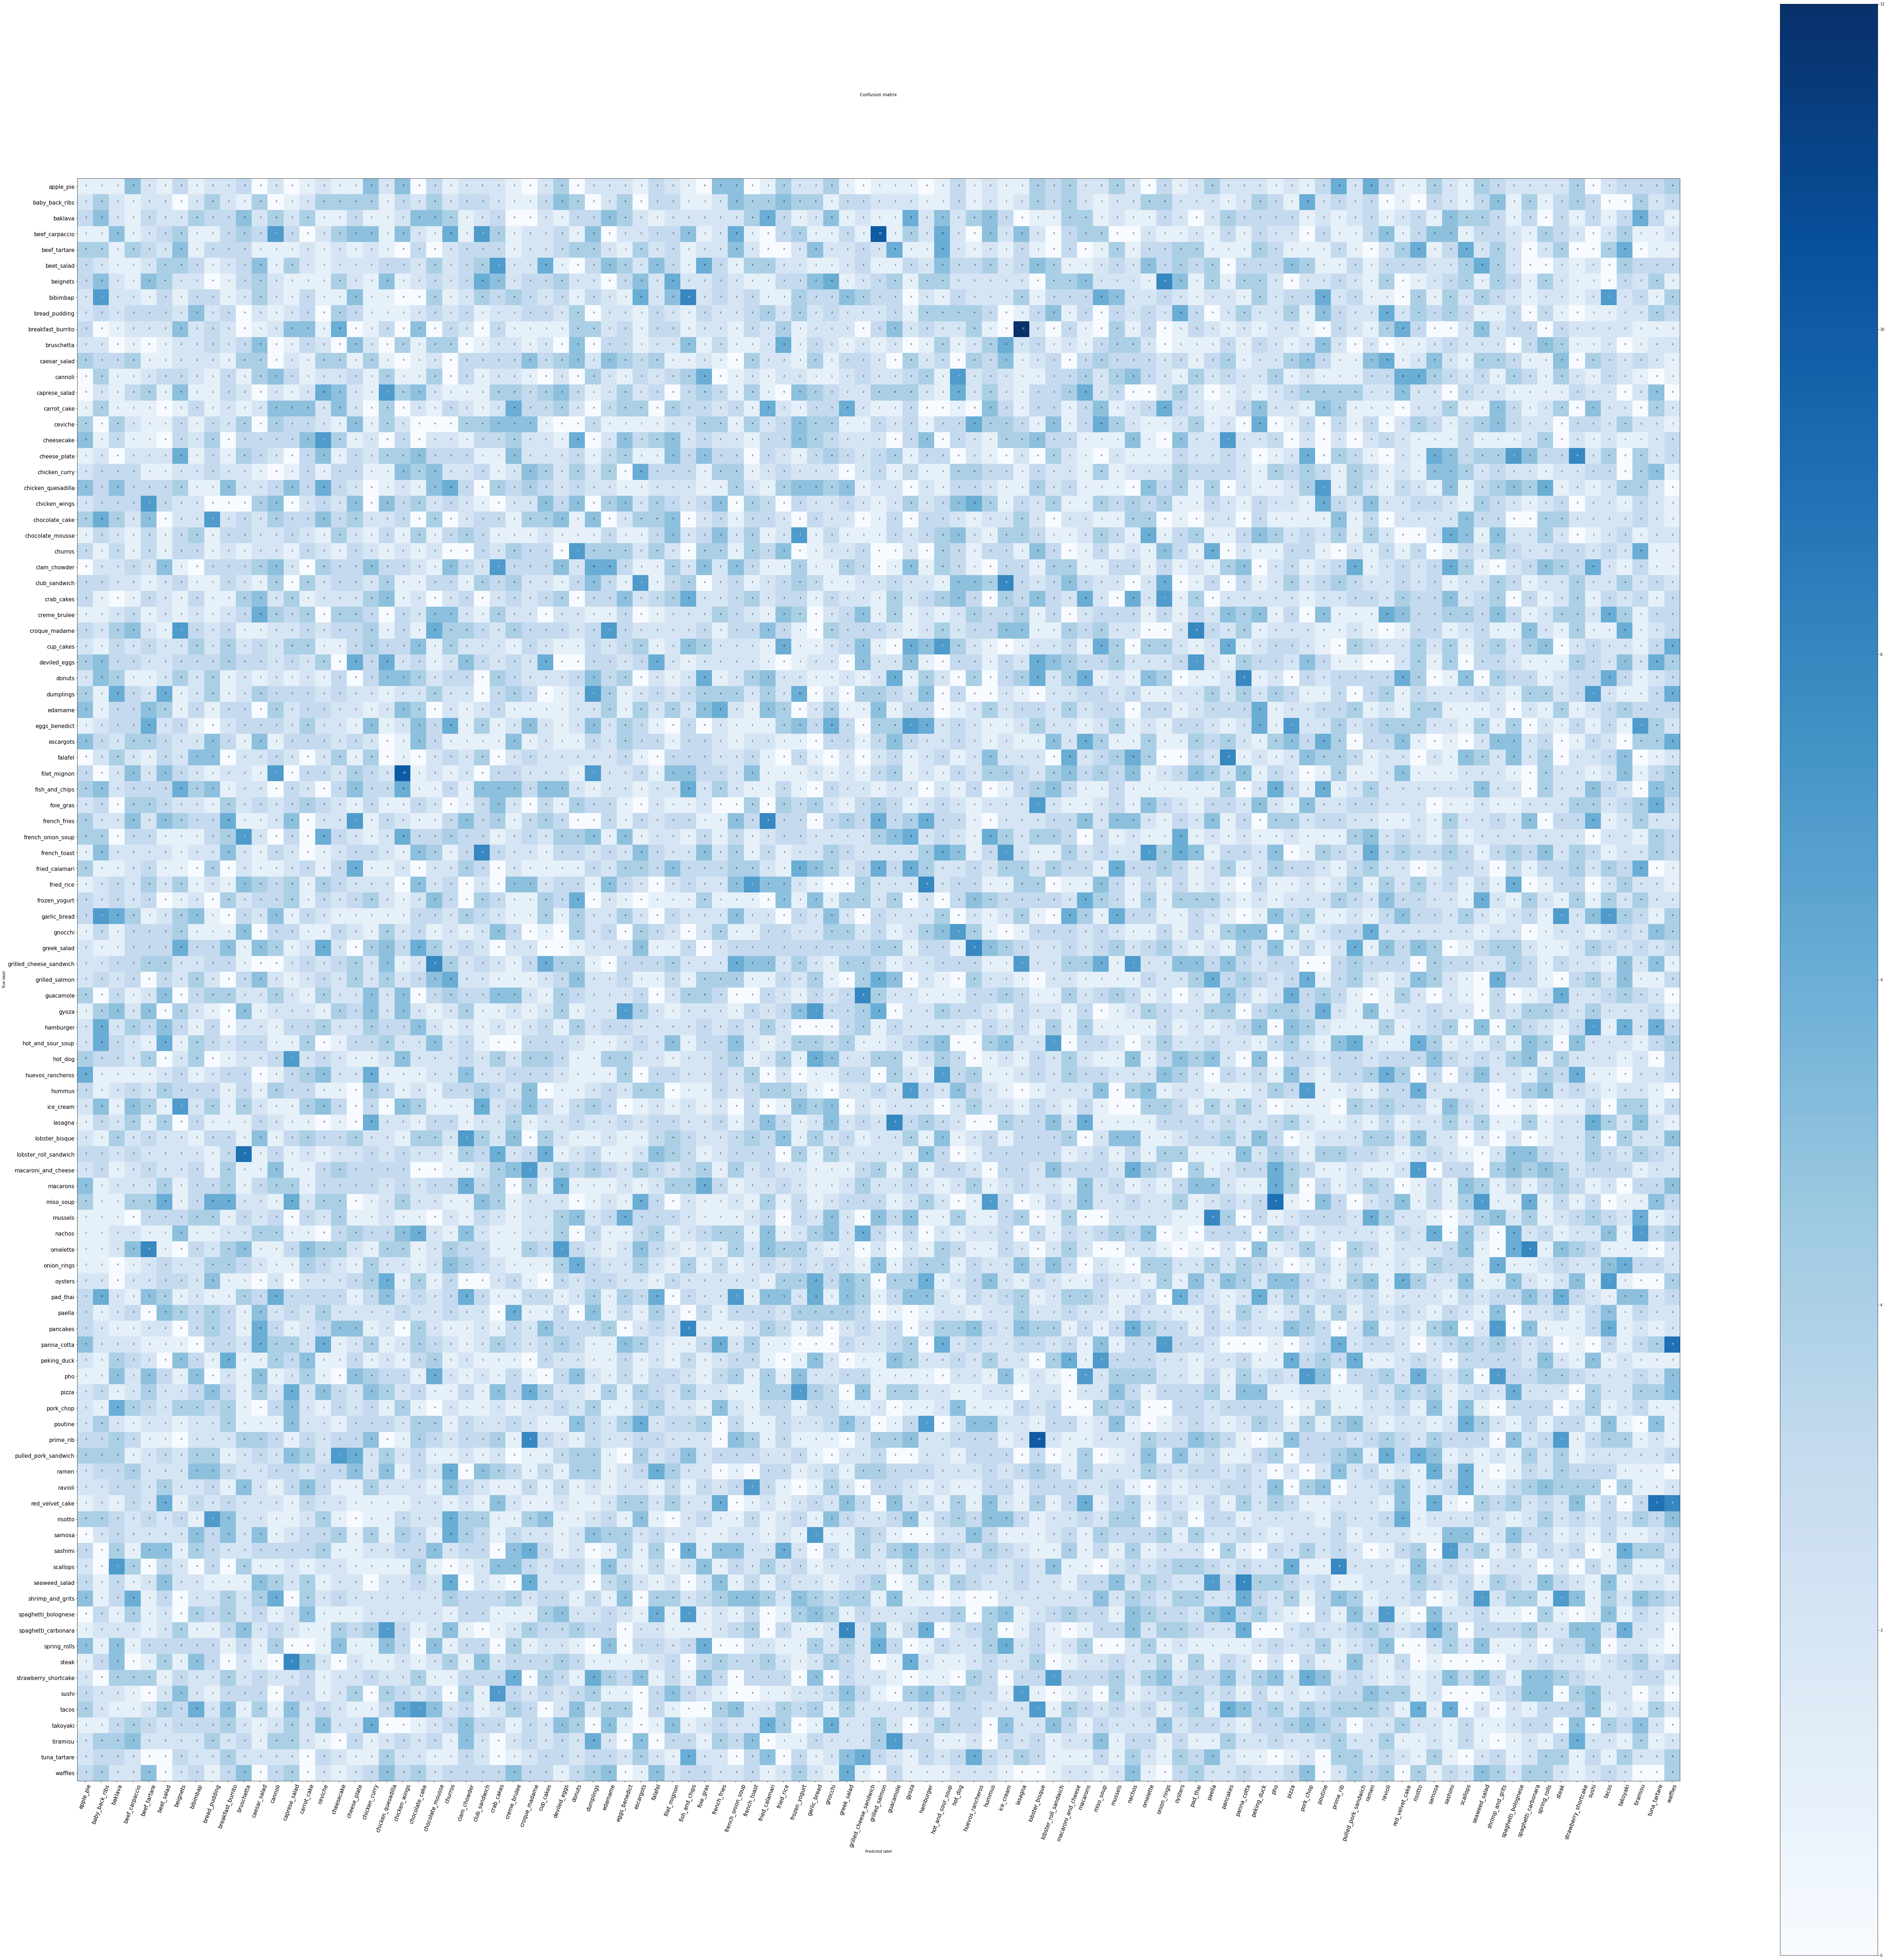

In [102]:
make_confusion_matrix(y_label,y_predicted,classes =class_names,figsize = (100,100),savefig = True)

In [98]:
from sklearn.metrics import classification_report
def make_f1_scores(y_labels,pred_classes,class_names,figsize = (12,25),savefig = True):
    '''
    Plot f1-scores of each label
    
    Arguments:
        y_labels --- the ground truth labels
        y_preds --- the predicted labels
        class_names --- all labels of predicted from the model
        figisze --- the figsize of model, default = (12,25)
        savefig --- Save figure option
    
    Return None
    '''
    # get the dictinary of the classification report, sklearn 
    classification_report_dict = classification_report(y_labels,pred_classes,output_dict = True)
    # create empty dictionary
    class_f1_scores = {}
    # look though classification report items
    for k,v in classification_report_dict.items():
        if k == "accuracy": # stop once we get to accuracy values
            break
        else:
            # Append class names and f1-scores to new dictionary
            class_f1_scores[class_names[int(k)]] = v['f1-score']
    # Turn f1-scores into dataframe for visualization
    f1_scores = pd.DataFrame({"class_name":list(class_f1_scores.keys()),
                             "f1-score": list(class_f1_scores.values())
                             }).sort_values("f1-score")
    fig,ax = plt.subplots(figsize = (12,25))
    scores = ax.barh(range(len(f1_scores)),f1_scores['f1-score'].values)
    ax.set_yticks(range(len(f1_scores))) #  create enough axis slot for axis
    ax.set_yticklabels(list(f1_scores['class_name'])) # get the label intoe
    ax.set_title("F1-Scores for 10 Different Classes")
    # ax.invert_yaxis() # reverse the order
    # attach a text label above each bar displaying its height (it's value)
    for score in scores:
        width = score.get_width() # also the f1-curves values
        ax.text(0.03 + width,score.get_y() + score.get_height()/1.5,
                f"{width:.2f}",
                ha = "center",
                va = "bottom"
               )
    if savefig:
        plt.savefig("f1-scores.png")


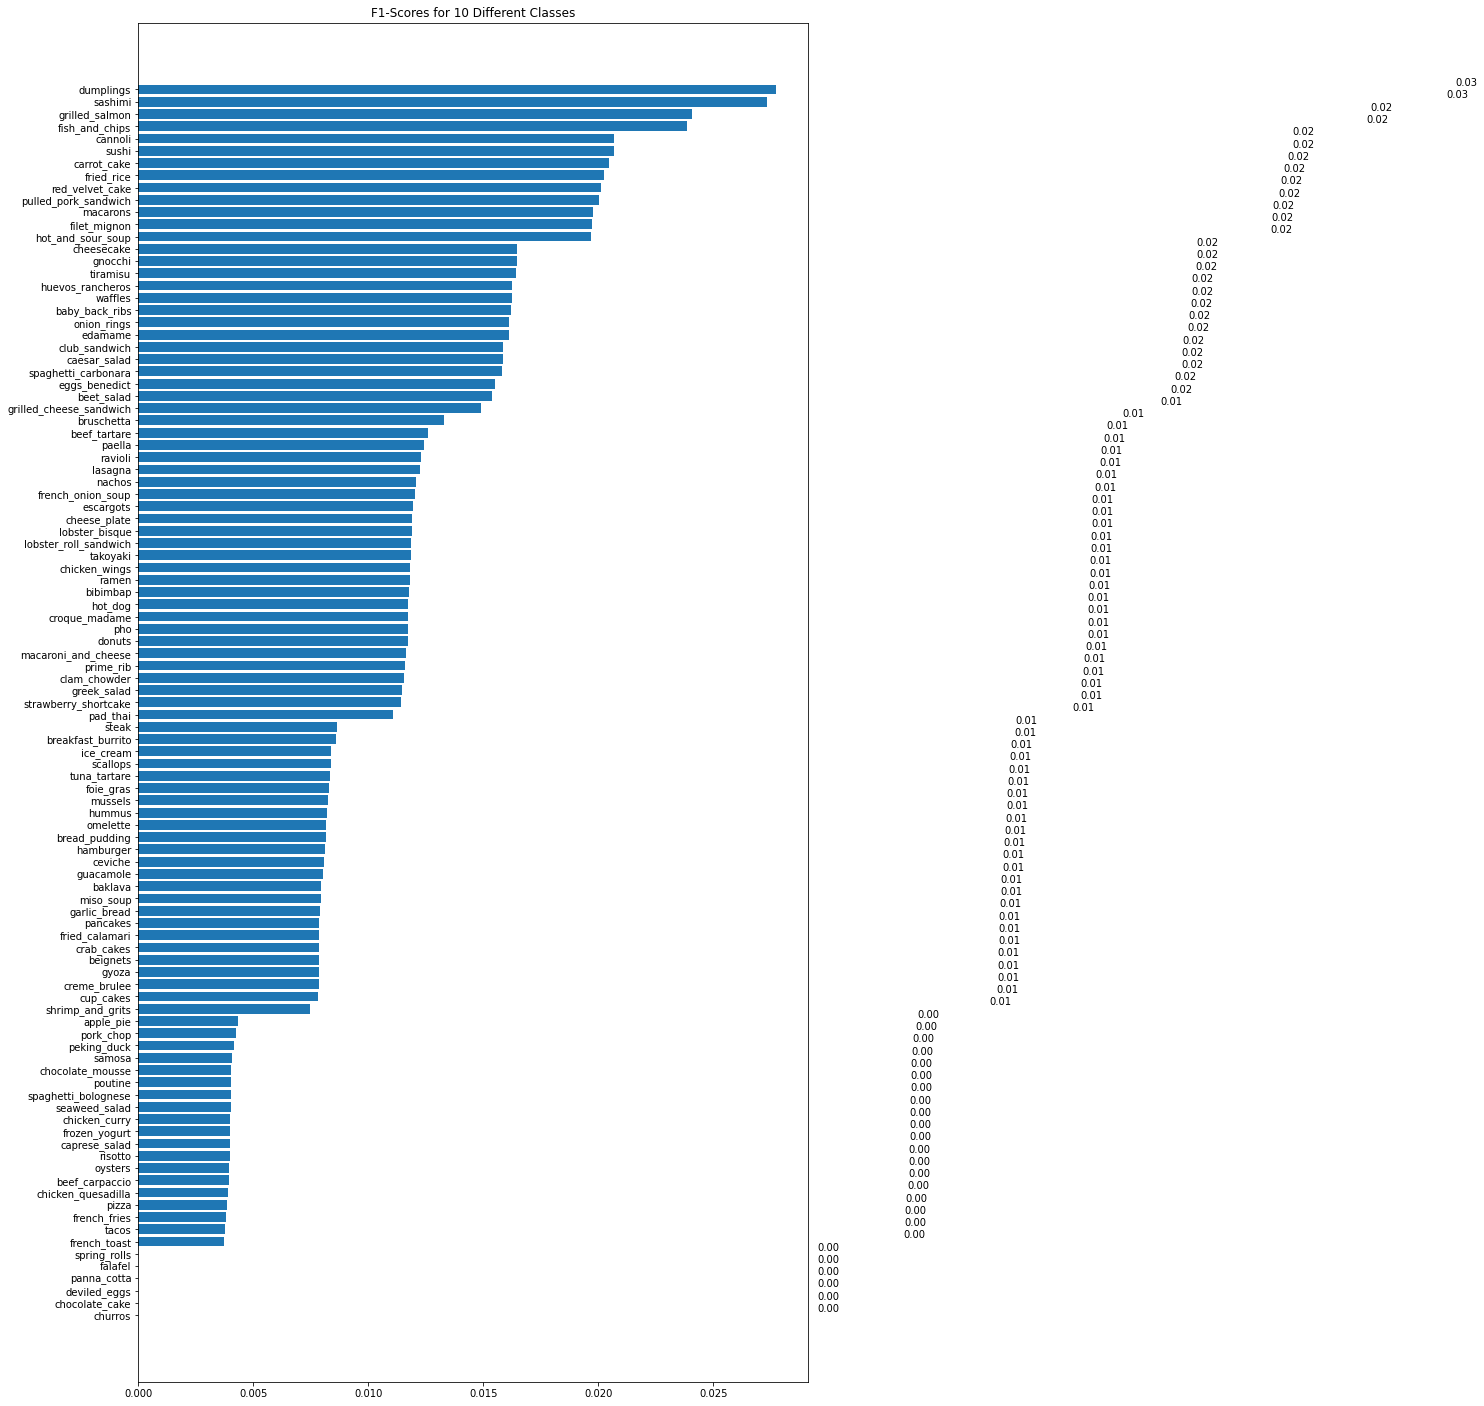

In [99]:
make_f1_scores(y_label,y_predicted,class_names,figsize = (12,25),savefig = True)

In [47]:
# Zip your model
!zip -r model_food101_fine_tuning.zip /content/model_food101_fine_tuning

updating: content/model_food101_fine_tuning/ (stored 0%)
updating: content/model_food101_fine_tuning/saved_model.pb (deflated 91%)
updating: content/model_food101_fine_tuning/keras_metadata.pb (deflated 96%)
updating: content/model_food101_fine_tuning/assets/ (stored 0%)
updating: content/model_food101_fine_tuning/variables/ (stored 0%)
updating: content/model_food101_fine_tuning/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/model_food101_fine_tuning/variables/variables.index (deflated 73%)


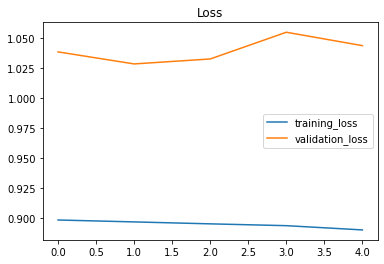

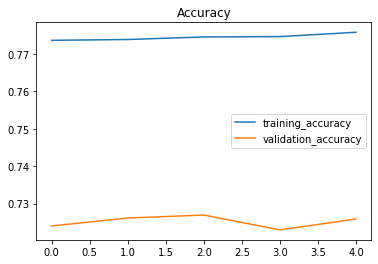

In [48]:
helper.plot_loss_curves(history_101_food_classes_all_data_fine_tune)

In [50]:
!tensorboard --logdir /content/training_logs/efficientNetB0_all_data_fine_tuning/20220331-080428


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)





--bind_all

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 320, in _exit_function
    def _exit_function(info=info, debug=debug, _run_finalizers=_run_finalizers,
KeyboardInterrupt


In [31]:
# ! tensorboard dev upload --logdir ./content/training_logs \
# --name "efficientNetB0_all_data_fine_tuning" \
# --description "fine-tuning-100"


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./content/training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=hmV0mqDol3D30mVnSlZTR7Qk16bSdA&prompt=consent&access_ty